In [31]:
import io
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
# from tensorflow.keras.preprocessing import image

In [32]:
dt = "train"
years = [2000, 2001, 2003, 2004, 2006, 2007, 2008, 2010, 2011, 2012, 2013, 2015, 2016, 2017, 2018]

# dt = "test"
# years = [2002, 2005, 2009, 2014]

# dt = "check"
# years = [2019, 2020]

if not os.path.isdir(f"{dt}"):
    os.mkdir(f"{dt}")

In [33]:
curs_data = pd.read_csv(
    "big_20/EURUSD_H1_200001030000_201912312200.csv",
    sep=";",
    header=0,
    names=["date", "time", "open", "high", "low", "close", "tickvol", "vol", "spread"]
)

In [34]:
# year = pd.DataFrame(curs_data.date.map(lambda x: int(x.split(".")[0])).values, columns=["year"])
# curs_data = pd.concat([year, curs_data], axis=1)
# curs_data = curs_data[curs_data["year"].isin(years)]
# date_time = pd.DataFrame((curs_data.date + " " + curs_data.time).values,  columns=["date_time"])
# curs_data = pd.concat([date_time, curs_data], axis=1)

In [35]:
curs_data.head()

,date,time,open,high,low,close,tickvol,vol,spread
0,2000.01.03,00:00:00,1.0073,1.0132,1.0073,1.0128,194,0,50
1,2000.01.03,01:00:00,1.0129,1.0141,1.0120,1.0137,113,0,50
2,2000.01.03,02:00:00,1.0140,1.0173,1.0134,1.0171,149,0,50
3,2000.01.03,03:00:00,1.0170,1.0190,1.0170,1.0175,214,0,50
4,2000.01.03,04:00:00,1.0173,1.0177,1.0164,1.0167,162,0,50


In [36]:
curs_data.open.isnull().value_counts()

False    124108
Name: open, dtype: int64

In [37]:
data = curs_data[["open", "high", "low", "close"]].values
del curs_data

In [38]:
import math

step = 72
X = []
y = []
for i in range(step, data.shape[0]-1):
    win = data[i-step:i]
    res = data[i]
    if (math.isnan(win.max())) or (math.isnan(win.max())):
        print(list(win))
        break
    X.append(win)
    y.append(res)
X = np.array(X)
y = np.array(y)

In [39]:
X.shape[0]

124035

In [40]:
X[1][-1] == y[0]

array([ True,  True,  True,  True])

In [41]:
def data_to_img(data, size=(144, 216)):

    def get_point(value, min_value, max_value, max_coord):
        max_diff = max_value - min_value
        value_diff = value - min_value
        res = value_diff * 100 / max_diff
        return int(round(max_coord * res / 100))

    # data = data.astype(np.float16)
    rect_w = 3
    line_skip = 1
    max_h = size[0] - 1
    max_value = data[:,:1].max()
    min_value = data[:,:2].min()
    img = np.zeros(size, dtype=np.uint8)
    for x, values in zip(range(0, size[1], rect_w), data):
        y1 = get_point(values[0], min_value, max_value, max_h)
        y2 = get_point(values[3], min_value, max_value, max_h)
        rect = {
            "lx": x,
            "rx": x+rect_w,
            "ty": y1 if y1 < y2 else y2,
            "by": y2 if y1 <= y2 else y1
        }
        color = 127 if y1 > y2 else 255
        y1 = get_point(values[1], min_value, max_value, max_h)
        y2 = get_point(values[2], min_value, max_value, max_h)
        line = {
            "x": x+line_skip,
            "t": y1 if y1 < y2 else y2,
            "b": y2 if y1 <= y2 else y1
        }
        img[rect["ty"]:rect["by"], rect["lx"]:rect["rx"]] = color
        img[line["t"]:line["b"], line["x"]:line["x"]+1] = color
    return img / 255 * 0.2

In [42]:
img = data_to_img(X[-1])

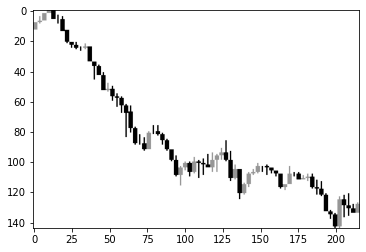

In [43]:
plt.imshow(img / 255, cmap="Greys")

In [44]:
X_imgs = []
for index, img in enumerate(X):
    X_imgs.append(data_to_img(img))
X_imgs = np.array(X_imgs, dtype=np.uint8)
X_imgs.shape

(124035, 144, 216)

In [45]:
np.save(f"{dt}/X_curs", X)
np.save(f"{dt}/X_imgs", X_imgs)
np.save(f"{dt}/y", y)
